In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pylab
import scipy as sp

1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```



In [2]:
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]

In [3]:
# cumulative probability
cprob = (np.arange(years_nb, dtype=np.float32) + 1)/(years_nb + 1)

# sort the max speeds from the data
sorted_ms = np.sort(max_speeds)

print(sorted_ms)

[22.46 23.2  23.34 23.85 24.16 25.28 25.79 26.19 26.37 26.65 26.65 26.68
 26.73 26.75 26.76 27.93 28.09 28.79 29.75 30.19 32.97]


In [4]:
# use of scipy
from scipy.interpolate import UnivariateSpline

quantile = UnivariateSpline(cprob, sorted_ms)

nprob = np.linspace(0, 1, 100)
fitted_ms = quantile(nprob)

In [5]:
# upper two quantile
fifty_prob = 1. - 0.02

In [6]:
fifty_wind = quantile(fifty_prob)
fifty_wind   

array(32.97989825)

Text(0, 0.5, 'Cumulative probability')

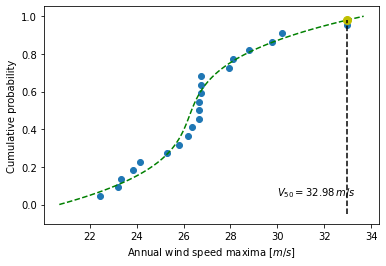

In [7]:
plt.figure()
plt.plot(sorted_ms, cprob, 'o')
plt.plot(fitted_ms, nprob, 'g--')
plt.plot([fifty_wind], [fifty_prob], 'o', ms=8., mfc='y', mec='y')
plt.text(30, 0.05, '$V_{50} = %.2f \, m/s$' % fifty_wind)
plt.plot([fifty_wind, fifty_wind], [plt.axis()[2], fifty_prob], 'k--')
plt.xlabel('Annual wind speed maxima [$m/s$]')
plt.ylabel('Cumulative probability')

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.
* Define a function that can describe min and max temperatures. 
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

In [8]:
max_temp = np.array([17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18])
min_temp = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])

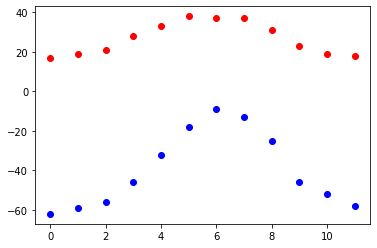

In [9]:
months = np.arange(12)
plt.plot(months, max_temp, 'ro')
plt.plot(months, min_temp, 'bo')

In [10]:
# define of the function that can describe min and max t
from scipy import optimize
def minmax_t(times, avg, ampl, time_offset):
    return (avg
            + ampl * np.cos((times + time_offset) * 2 * np.pi / times.max()))

In [11]:
# fitting
res_max, cov_max = optimize.curve_fit(minmax_t, months,
                                      max_temp, [20, 10, 0])
res_min, cov_min = optimize.curve_fit(minmax_t, months,
                                      min_temp, [-40, 20, 0])

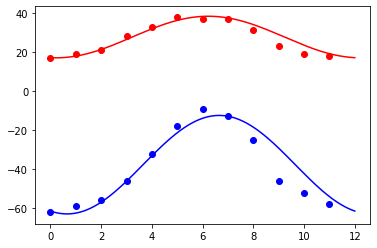

In [12]:
# plotting the fitted functions
days = np.linspace(0, 12, num=365)

plt.figure()
plt.plot(months, max_temp, 'ro')
plt.plot(days, minmax_t(days, *res_max), 'r-')
plt.plot(months, min_temp, 'bo')
plt.plot(days, minmax_t(days, *res_min), 'b-')

plt.show()

3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


In [54]:
def sixhump(x):
    return ((4 - 2.1*x[0]**2 + x[0]**4 / 3.) * x[0]**2 + x[0] * x[1]
            + (-4 + 4*x[1]**2) * x[1] **2)

In [55]:
# Make a grid to evaluate the function (for plotting)
x = np.linspace(-2, 2)
y = np.linspace(-1, 1)
xm, ym = np.meshgrid(x, y)

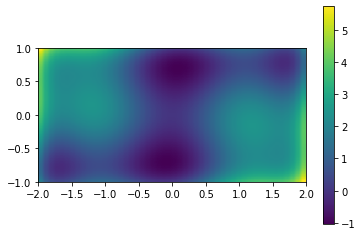

In [56]:
plt.figure()
plt.imshow(sixhump([xm, ym]), extent=[-2, 2, -1, 1]) # bounds
plt.colorbar()

Text(0.5, 0, 'f(x, y)')

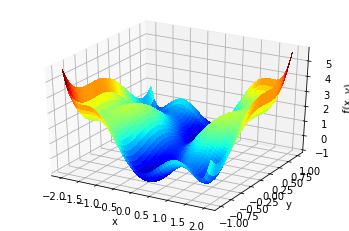

In [58]:
# for 3D representation
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(xm, ym, sixhump([xm, ym]), rstride=1, cstride=1,
                       cmap=plt.cm.jet, linewidth=0, antialiased=False)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')

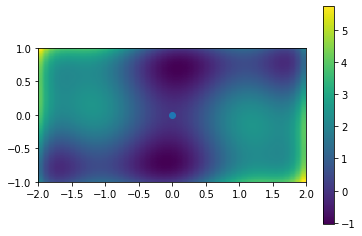

In [62]:
x_min = optimize.minimize(sixhump, x0=[0, 0])

plt.figure()
# Show the function in 2D
plt.imshow(sixhump([xm, ym]), extent=[-2, 2, -1, 1])
plt.colorbar()
# And the minimum that we've found:
plt.scatter(x_min.x[0], x_min.x[1])

plt.show()

4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

In [18]:
! wget https://www.dropbox.com/s/3vigxoqayo389uc/populations.txt

--2020-12-01 19:06:36--  https://www.dropbox.com/s/3vigxoqayo389uc/populations.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.1, 2620:100:6025:1::a27d:4501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/3vigxoqayo389uc/populations.txt [following]
--2020-12-01 19:06:37--  https://www.dropbox.com/s/raw/3vigxoqayo389uc/populations.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfc2eec17ac6a5cbc8252f01eff.dl.dropboxusercontent.com/cd/0/inline/BER59KZ3y_pWgZg_5wCGFiBqBNLnYMEyTghch65Q1N45Cy1tWLAEsOpd_REcD_8-C4fmU7vzB3d-s9YObHBaq0gAtNqREhtsKaEJ8ApAk5e4Hg/file# [following]
--2020-12-01 19:06:37--  https://ucfc2eec17ac6a5cbc8252f01eff.dl.dropboxusercontent.com/cd/0/inline/BER59KZ3y_pWgZg_5wCGFiBqBNLnYMEyTghch65Q1N45Cy1tWLAEsOpd_REcD_8-C4fmU7vzB3d-s9YObHBaq0gAtNqREhtsKaEJ8ApAk5e4Hg/file
Resolvi

In [31]:
from scipy import fftpack
# import txt file data
filename = "populations.txt"
df = pd.read_csv(filename, sep="	", skiprows=1, header=None)
df.columns = ["year", "hare", "lynx", "carrot"]
df = df.drop(["year"], axis=1) # drop the year column, not useful for the analysis
df

,hare,lynx,carrot
0,30000.0,4000.0,48300
1,47200.0,6100.0,48200
2,70200.0,9800.0,41500
3,77400.0,35200.0,38200
4,36300.0,59400.0,40600
5,20600.0,41700.0,39800
6,18100.0,19000.0,38600
7,21400.0,13000.0,42300
8,22000.0,8300.0,44500
9,25400.0,9100.0,42100


<Figure size 1600x800 with 0 Axes>

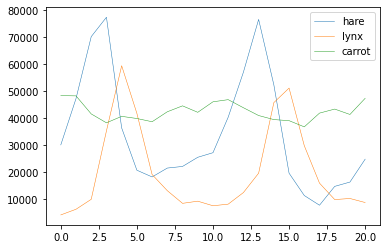

In [32]:
plt.figure(figsize=(16,8), dpi= 100)
df.plot(linewidth = 0.5)

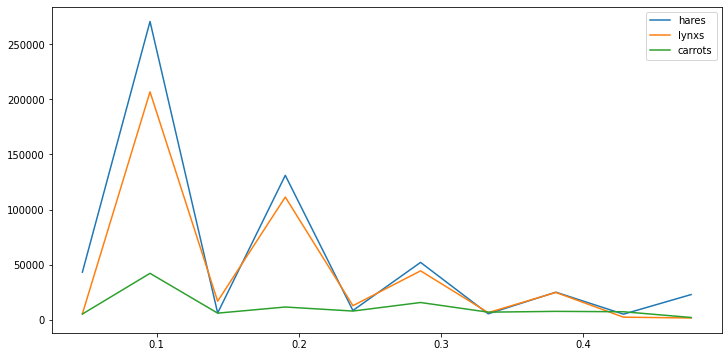

In [51]:
# fft on the data
hares_fft = fftpack.fft(df["hare"].tolist())
lynxs_fft = fftpack.fft(df["lynx"].tolist())
carrots_fft = fftpack.fft(df["carrot"].tolist())

time_step = 1
hares_f = fftpack.fftfreq(len(df["hare"].tolist()), d = time_step)
lynxs_f = fftpack.fftfreq(len(df["lynx"].tolist()), d =time_step)
carrots_f = fftpack.fftfreq(len(df["carrot"].tolist()), d = time_step)

positive_freq = np.where(hares_f > 0)

plt.figure(figsize = (12,6))
plt.plot(hares_f[positive_freq], abs(hares_fft[positive_freq]), label = 'hares')
plt.plot(lynxs_f[positive_freq], abs(lynxs_fft[positive_freq]), label = 'lynxs')
plt.plot(carrots_f[positive_freq], abs(carrots_fft[positive_freq]), label = 'carrots')
plt.legend();

5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.

In [21]:
moonlanding = pylab.imread("moonlanding.png")

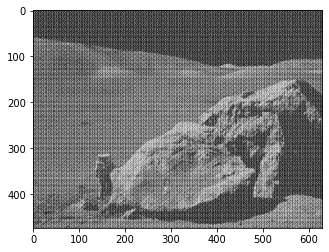

In [22]:
from scipy import fftpack
im_fft = fftpack.fft2(moonlanding)
plt.figure()
plt.imshow(moonlanding,  plt.cm.gray)

Text(0.5, 1.0, 'Fourier transform')

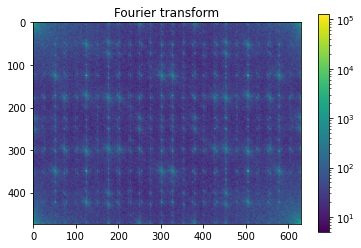

In [23]:
from matplotlib.colors import LogNorm
plt.figure()
plt.imshow(np.abs(im_fft), norm=LogNorm(vmin=5))
plt.colorbar()
plt.title('Fourier transform')

Text(0.5, 1.0, 'Filtered Spectrum')

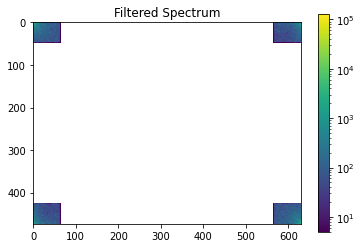

In [24]:
keep_fraction = 0.1
im_fft2 = im_fft.copy()
r, c = im_fft2.shape
# set to zero the componenets
im_fft2[int(r*keep_fraction):int(r*(1-keep_fraction))] = 0 # rows
im_fft2[:, int(c*keep_fraction):int(c*(1-keep_fraction))] = 0 # columns

plt.figure()
plt.imshow(np.abs(im_fft2), norm=LogNorm(vmin=5))
plt.colorbar()
plt.title('Filtered Spectrum')

Text(0.5, 1.0, 'Reconstructed Image')

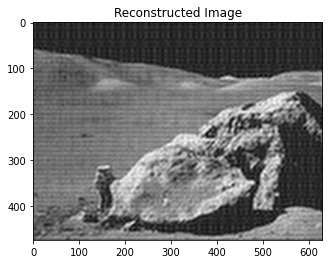

In [25]:
im_new = fftpack.ifft2(im_fft2).real

plt.figure()
plt.imshow(im_new, plt.cm.gray)
plt.title('Reconstructed Image')